In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose 
import statsmodels.tsa.stattools as sts 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from pmdarima.arima import auto_arima
import seaborn as sns

sns.set_style("darkgrid")
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

In [2]:
### Function to convert dataframe to timeseries object
def create_ts_object(df):
    df.Timestamp = pd.to_datetime(df.Timestamp)
    df.set_index("Timestamp", inplace=True)
    df = df.asfreq('H')

    return df.head()

### Import Digester 22 data

In [3]:
data22 = pd.read_csv("~/Documents/Data/FinalDatasetForModel/Digester22data.csv")
data22.drop(['Dig_22_woodload', 'Dig_22_Liq_circ',
       'Digester_22_temperature', 'Digester_22_pressure',
       'Dig_22_phase_Comm Fail', 'Dig_22_phase_Configure',
       'Dig_22_phase_HP GAS RELEASE', 'Dig_22_phase_LIQUOR LOADING',
       'Dig_22_phase_LP GAS RELEASE', 'Dig_22_phase_PULP DISCHARGE',
       'Dig_22_phase_READY FOR LIQUOR',
       'Dig_22_phase_READY FOR PULP DISCH',
       'Dig_22_phase_READY FOR STEAMING', 'Dig_22_phase_READY FOR WOOD',
       'Dig_22_phase_SFACTOR TGT REACHED',
       'Dig_22_phase_SMOOTH STEAM FIXED',
       'Dig_22_phase_SMOOTH STEAM RAMP', 'Dig_22_phase_Scan Timeout',
       'Dig_22_phase_TEMP RAMP TO 110C', 'Dig_22_phase_TEMP RAMP TO 126C',
       'Dig_22_phase_TEMP RAMP TO TMAX', 'Dig_22_phase_VALVE CHECK',
       'Dig_22_phase_WOODLOAD COMPLETE', 'Dig_22_phase_WOODLOADING'], axis = 1, inplace=True)

create_ts_object(data22)

,Dig_22_HX
Timestamp,
2020-11-01 00:00:00,2.140194
2020-11-01 01:00:00,1.066862
2020-11-01 02:00:00,0.376167
2020-11-01 03:00:00,0.399351
2020-11-01 04:00:00,0.477727


### Stationarity

In [4]:
sts.adfuller(data22.Dig_22_HX)

(-8.58138786895037,
 7.711475990707115e-14,
 19,
 2189,
 {'1%': -3.4333408565184294,
  '5%': -2.8628612620249507,
  '10%': -2.5674733728800154},
 10814.69681843171)

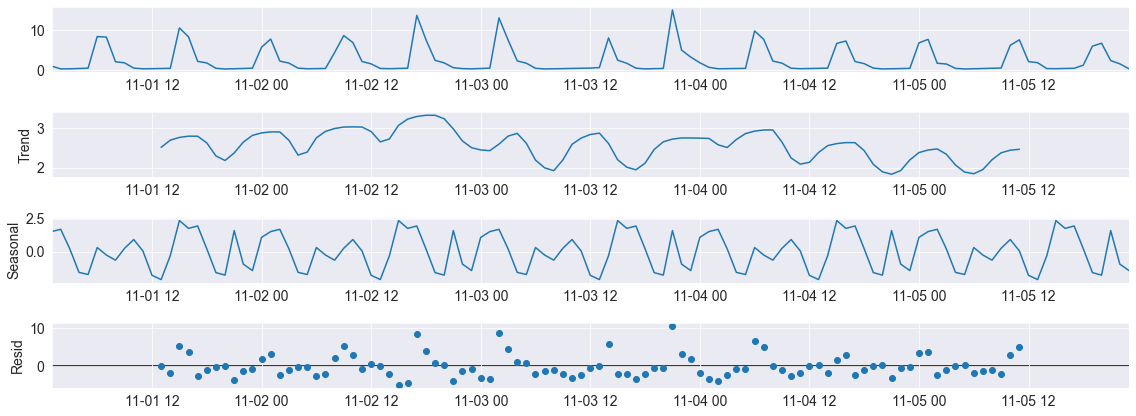

In [5]:
seas_dec = seasonal_decompose(data22[1:120], model = "additive")
seas_dec.plot()
plt.show()

### ACF

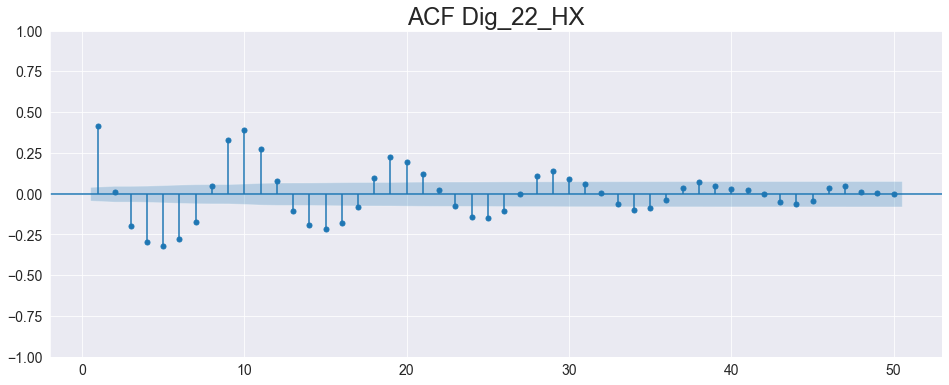

In [6]:
sgt.plot_acf(data22.Dig_22_HX, lags = 50, zero = False)
plt.title("ACF Dig_22_HX", size = 24)
plt.show()

### PACF

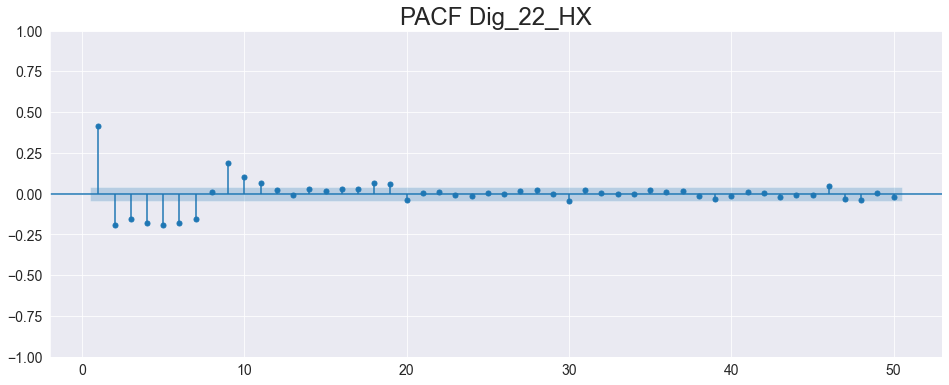

In [7]:
sgt.plot_pacf(data22.Dig_22_HX, lags = 50, zero = False, method = ('ols'))
plt.title("PACF Dig_22_HX", size = 24)
plt.show()

In [8]:
#  Spare copy
data22_twin1 = data22.copy()

### Normalization

In [9]:
# define functions to scale and reverse-scale data, looping through the columns, and passing a scaler type
def scale_data(data, scaler):
    for col in data.columns.values:
        data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
    return data.head()

In [10]:
scaler = MinMaxScaler()
data22_twin = data22.copy()
scale_data(data22_twin, scaler)

,Dig_22_HX
Timestamp,
2020-11-01 00:00:00,0.127584
2020-11-01 01:00:00,0.054769
2020-11-01 02:00:00,0.007912
2020-11-01 03:00:00,0.009485
2020-11-01 04:00:00,0.014802


### Data Split

In [11]:
train_size = int(len(data22_twin)*0.85)
val_size = train_size + int(len(data22_twin)*0.10)
train_data22 = data22_twin.iloc[:train_size]
val_data22 = data22_twin.iloc[train_size:val_size]
test_data22 = data22_twin.iloc[val_size:]

In [12]:
val_data22.head()

,Dig_22_HX
Timestamp,
2021-01-18 05:00:00,0.016869
2021-01-18 06:00:00,0.484436
2021-01-18 07:00:00,0.523628
2021-01-18 08:00:00,0.095500
2021-01-18 09:00:00,0.060738


### Auto ARIMA Model

In [13]:
model_auto = auto_arima(train_data22.Dig_22_HX, max_order = None, max_p = 30, max_q = 40, maxiter = 100, alpha = 0.05, n_jobs = -1, trend = 'ct',)

C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
C:\Users\USER\AppData\Local\Programs\Python\Pyt

In [14]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1877
Model:               SARIMAX(1, 1, 2)   Log Likelihood                  85.407
Date:                Sat, 12 Mar 2022   AIC                           -158.815
Time:                        13:13:38   BIC                           -125.593
Sample:                             0   HQIC                          -146.577
                               - 1877                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0002      0.001     -0.235      0.814      -0.001       0.001
drift      -1.446e-07   4.36e-07     -0.332      0.740   -9.99e-07     7.1e-07
ar.L1          0.5865      0.084      6.965      0.000       0.421       0.752
ma.L1         -0.8697      0.083    -10.480      0.000      -1.032      -0.707
ma.L2         -0.0968      0.065     -1.491      0.136      -0.224       0.030
sigma2         0.0595      0.003     20.815      0.000       0.054       0.065
===================================================================================
Ljung-Box (L1) (Q):                  37.79   Jarque-Bera (JB):              7220.19
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                             2.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARIMA Model Residual Analysis

In [15]:
data22_resid_dataset = train_data22.copy()
data22_resid_dataset['residuals'] = model_auto.resid()

In [16]:
print(data22_resid_dataset.residuals.mean())
print(data22_resid_dataset.residuals.var())

0.008442330455399662
0.053047094103557284


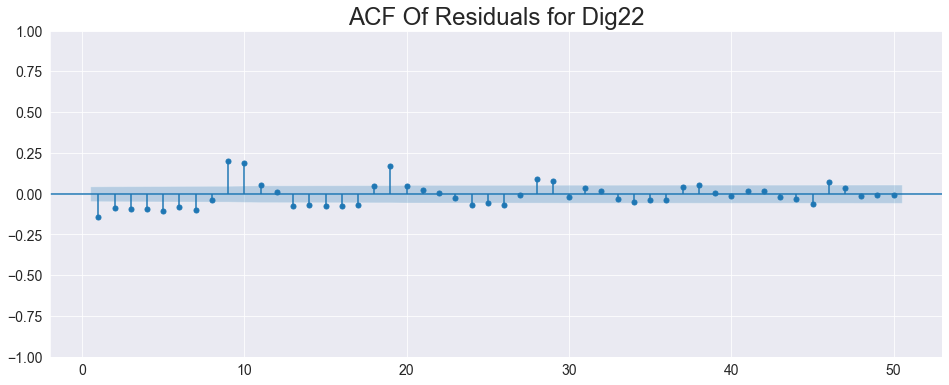

In [17]:
sgt.plot_acf(data22_resid_dataset.residuals, zero = False, lags = 50)
plt.title("ACF Of Residuals for Dig22",size=24)
plt.show()

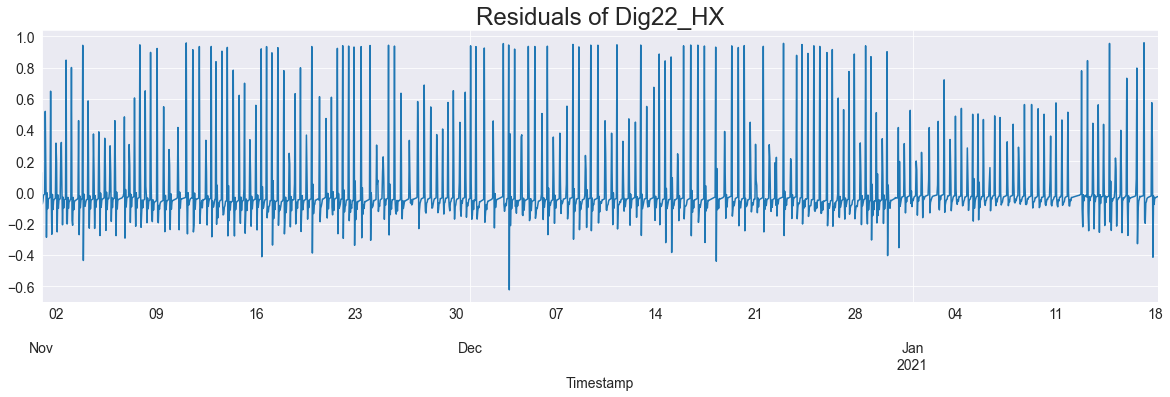

In [18]:
data22_resid_dataset.residuals.plot(figsize=(20,5))
plt.title("Residuals of Dig22_HX",size=24)
plt.show()

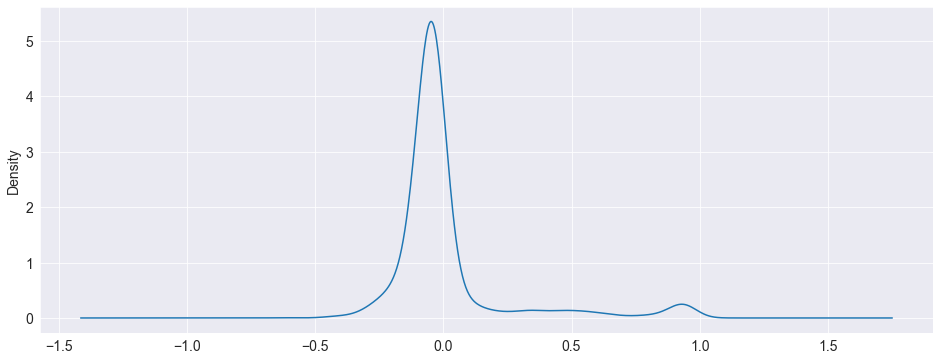

In [19]:
data22_resid_dataset.residuals.plot(kind='kde')
plt.show()

### Model Validation

In [20]:
start_date = "2021-01-18 05:00:00"
end_date = "2021-01-27 08:00:00"

In [21]:
df_pred = pd.DataFrame(model_auto.predict(n_periods = len(val_data22), index = val_data22.index))

In [22]:
scaler2 = MinMaxScaler()
scaler2.fit_transform(data22_twin1.Dig_22_HX.values.reshape(-1, 1))

array([[0.12758445],
       [0.05476909],
       [0.007912  ],
       ...,
       [0.06706818],
       [0.01266117],
       [0.01344693]])

In [23]:
# Invert the scale of predictions
df_pred2 = scaler2.inverse_transform(df_pred.values.reshape(-1, 1))

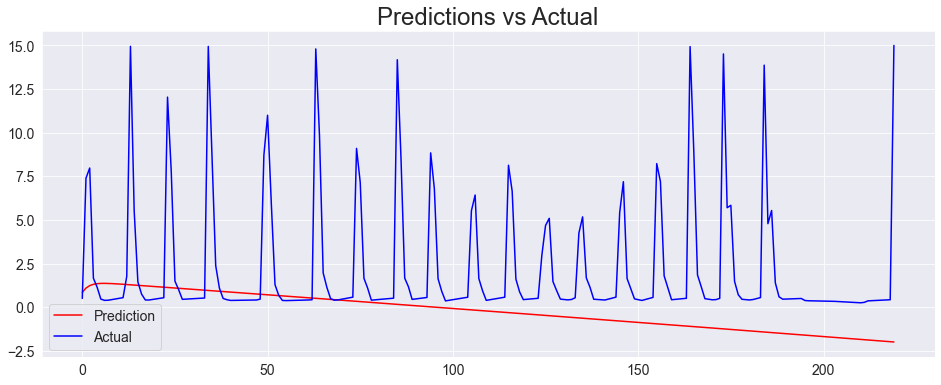

In [24]:
plt.plot(df_pred.index.to_numpy(), df_pred2, color = "red")
plt.plot(df_pred.index, data22_twin1.Dig_22_HX[start_date:end_date].to_numpy(), color = "blue")
plt.legend(['Prediction', 'Actual'])
plt.title("Predictions vs Actual", size = 24)
plt.show()

### Performance Metrics

In [25]:
ndapred, ndaactual = df_pred, val_data22.Dig_22_HX.to_numpy()

In [26]:
print(ndapred.shape)
print(ndaactual.shape)

(220, 1)
(220,)


In [27]:
print("MAE: %.4f" %mean_absolute_error(ndaactual, ndapred))
print("RMSE: %.4f" %np.sqrt(mean_squared_error(ndaactual, ndapred)))

MAE: 0.1720
RMSE: 0.2867


In [28]:
np.save("C:/Users/USER/Documents/PythonModels/Linear/Composite predictions/Dig22pred.npy", df_pred2)

### Forecast

In [29]:
fcast = pd.DataFrame(model_auto.predict(n_periods = len(test_data22), index = test_data22.index))

In [32]:
fcast = scaler2.inverse_transform(fcast.values.reshape(-1, 1))

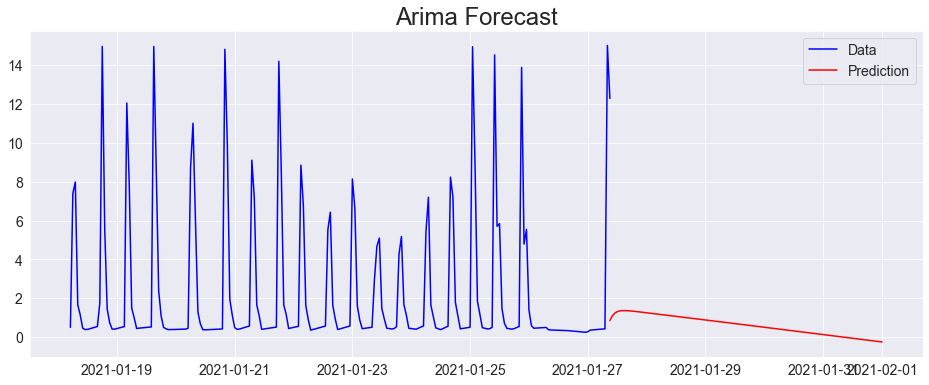

In [33]:
plt.plot(data22_twin1.index[1877:2098], data22_twin1.Dig_22_HX[1877:2098].to_numpy(), color = "blue")
plt.plot(test_data22.index, fcast, color = "red")
plt.legend(['Data', 'Prediction'])
plt.title("Arima Forecast", size = 24)
plt.show()

In [31]:
np.save("C:/Users/USER/Documents/PythonModels/Linear/Composite predictions/Dig22fcast.npy", fcast)